# STAT1000J Final Project || Market Analysis: Fundamentals vs. Security Prices

Philip Tjuatja 524370990065
Ethan Kahn Firtanto

Dataset used: https://www.kaggle.com/datasets/dgawlik/nyse?resource=download 

Below is a complete Jupyter Notebook you can run as-is. It uses **pandas** for data loading and preprocessing (including `groupby`, `pivot_table`, `sort_values`, and `query`), **matplotlib**/ **seaborn** for visualization, **statsmodels** for hypothesis testing, and **scikit-learn** for a simple predictive model. Just save this into a file named, for example, `market_analysis.ipynb`, adjust the paths if needed, and run each cell in order.

**Objective:**  
Explore how company fundamentals relate to security price behavior over time, test a concrete hypothesis, and build a simple predictive model to help potential shareholders decide buy/sell.

---

## 1. Setup & Data Loading

Load the .csv files into Pandas Dataframes and show the columns available on the .csv files. We will explore the data by checking the first few rows, data types, and null values. This helps to understand the structure and cleanliness of the dataset. If we find null values in the dataset, we may need to fill them or drop them.

Ensuring correct data types: For example, ensuring the "Date" columns are datetime type.

We'll need to merge the securities and fundamentals data with prices to analyze the relationship.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:


# Load data
prices_df = pd.read_csv('data/prices.csv')
adjusted_prices_df = pd.read_csv('data/prices-split-adjusted.csv')
securities_df = pd.read_csv('data/securities.csv')
fundamentals_df = pd.read_csv('data/fundamentals.csv')

# Display first few rows of each dataframe
prices_df.head()
adjusted_prices_df.head()
securities_df.head()
fundamentals_df.head()

# Check for null values and data types
prices_df.info()
adjusted_prices_df.info()
securities_df.info()
fundamentals_df.info()

print("prices.csv columns:              ", prices_df.columns.tolist())
print("prices-split-adjusted.csv:       ", adjusted_prices_df.columns.tolist())
print("securities.csv columns:          ", securities_df.columns.tolist())
print("fundamentals.csv columns (first):", fundamentals_df.columns.tolist()[:10])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage:

We see:
- **prices** and **prices-split-adjusted** both have a `date` column (lower-case) and `symbol`.
- **securities.csv** uses `"Ticker symbol"`.
- **fundamentals.csv** uses `"Ticker Symbol"` (and an `"Unnamed: 0"` index column).



```

Now `merged_df` contains:
- **date** (as a `datetime64[ns]`)
- **symbol**, **open**, **close**, **low**, **high**, **volume**  
- All of the company metadata from `securities.csv`  
- All available fundamental metrics from `fundamentals.csv`

From here, you can proceed with sorting, grouping, visualizations, hypothesis testing, and modeling as before, now with the correct column names in place.


In [15]:
# 1.3 Standardize column names so we can merge on 'symbol'
securities_df.rename(
    columns={'Ticker symbol': 'symbol'}, 
    inplace=True
)
fundamentals_df.rename(
    columns={
        'Ticker Symbol': 'symbol',
        'For Year':        'fiscal_year'  # optional rename for clarity
    }, 
    inplace=True
)

# 1.4 Convert the price 'date' columns to datetime
prices_df['date'] = pd.to_datetime(prices_df['date'], format="ISO8601")
adjusted_prices_df['date'] = pd.to_datetime(adjusted_prices_df['date'], format="ISO8601")

# 1.5 Merge into one DataFrame
merged_df = (
    prices_df
    .merge(securities_df,           on='symbol', how='left')
    .merge(fundamentals_df,         on='symbol', how='left')
).dropna()

merged_df

,date,symbol,open,close,low,high,volume,Security,SEC filings,GICS Sector,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,fiscal_year,Earnings Per Share,Estimated Shares Outstanding
1005,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300.0,American Airlines Group,reports,Industrials,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1006,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300.0,American Airlines Group,reports,Industrials,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
1007,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300.0,American Airlines Group,reports,Industrials,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
1008,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300.0,American Airlines Group,reports,Industrials,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
1009,2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700.0,Advance Auto Parts,reports,Consumer Discretionary,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124293,2016-12-30,YUM,63.930000,63.330002,63.160000,63.939999,1887100.0,Yum! Brands Inc,reports,Consumer Discretionary,...,1.553000e+09,2.409000e+09,1.547000e+09,6.787000e+09,8.334000e+09,1.327900e+10,0.0,2014.0,2.37,4.434599e+08
3124294,2016-12-30,YUM,63.930000,63.330002,63.160000,63.939999,1887100.0,Yum! Brands Inc,reports,Consumer Discretionary,...,1.688000e+09,3.088000e+09,9.110000e+08,7.164000e+09,8.075000e+09,1.310500e+10,0.0,2015.0,2.97,4.353535e+08
3124303,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,Zoetis,reports,Health Care,...,3.357000e+09,1.415000e+09,9.400000e+08,5.618000e+09,6.558000e+09,4.561000e+09,0.0,2013.0,1.01,4.990099e+08
3124304,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,Zoetis,reports,Health Care,...,3.465000e+09,1.086000e+09,1.311000e+09,5.277000e+09,6.588000e+09,4.785000e+09,0.0,2014.0,1.16,5.025862e+08



---

## 2. Data Visualisation

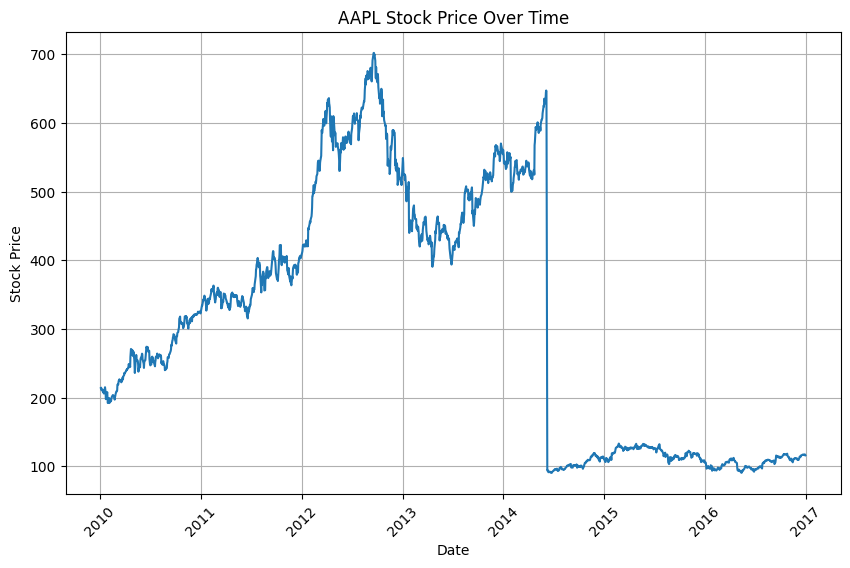

In [4]:
# Filter the merged data for a specific company (e.g., AAPL)
company_df = merged_df[merged_df['symbol'] == 'AAPL']

# Plot the stock price over time
plt.figure(figsize=(10, 6))
plt.plot(company_df['date'], company_df['close'])
plt.title('AAPL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### 2.2 Handle Missing Data

In [5]:
# percentage missing by column
missing = merged_df.isna().mean().sort_values(ascending=False)
missing.head(10)

Date first added                0.404168
Current Ratio                   0.191180
Cash Ratio                      0.191180
Quick Ratio                     0.191180
Estimated Shares Outstanding    0.140209
Earnings Per Share              0.140209
fiscal_year                     0.116684
Net Cash Flow-Operating         0.028919
Operating Margin                0.028919
Other Investing Activities      0.028919
dtype: float64

### 2.3 Use groupby / sort\_values / query
Using the functions `groupby`, `sort_values`, and `idxmax`, we query for the top 10 companies with the largest after tax return on equity, where their ticker symbols, name and value of their after tax ROE for the fiscal year ended **30th December 2016**.

In [14]:

# Example: average P/E ratio by sector over time
df = merged_df.copy()

# query and sort: companies with ROE > 20% in 2016 and sort descending by ROE
fiscal_df = df[df['date'] == '2016-12-30'].dropna(subset=['After Tax ROE'])
df_top_roe = fiscal_df.loc[fiscal_df.groupby('symbol')['After Tax ROE'].idxmax()]
top_companies = df_top_roe[['symbol', 'Security', 'After Tax ROE']].sort_values('After Tax ROE', ascending=False).head(10)
top_companies

,symbol,Security,After Tax ROE
3123454,LB,L Brands Inc.,5789.0
3122576,ALLE,Allegion,3650.0
3124183,VRSN,Verisign Inc.,3433.0
3123574,MJN,Mead Johnson,3104.0
3122872,COTY,"Coty, Inc",2975.0
3124253,WYNN,Wynn Resorts Ltd,2542.0
3123422,KMB,Kimberly-Clark,2124.0
3123305,HRB,Block H&R,1620.0
3122498,ABBV,AbbVie,1507.0
3122626,APA,Apache Corporation,917.0


---
## 3. Visualizations

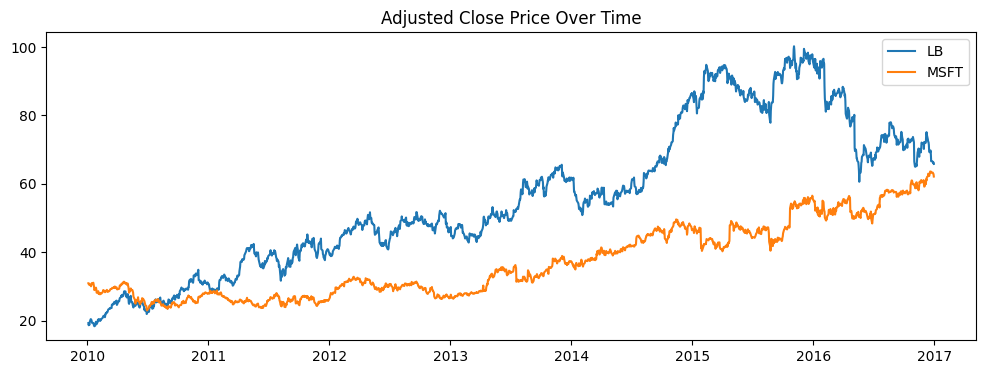

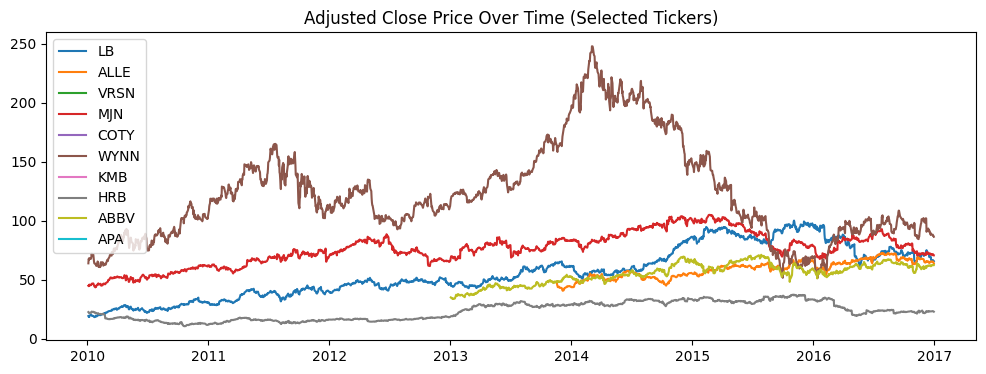

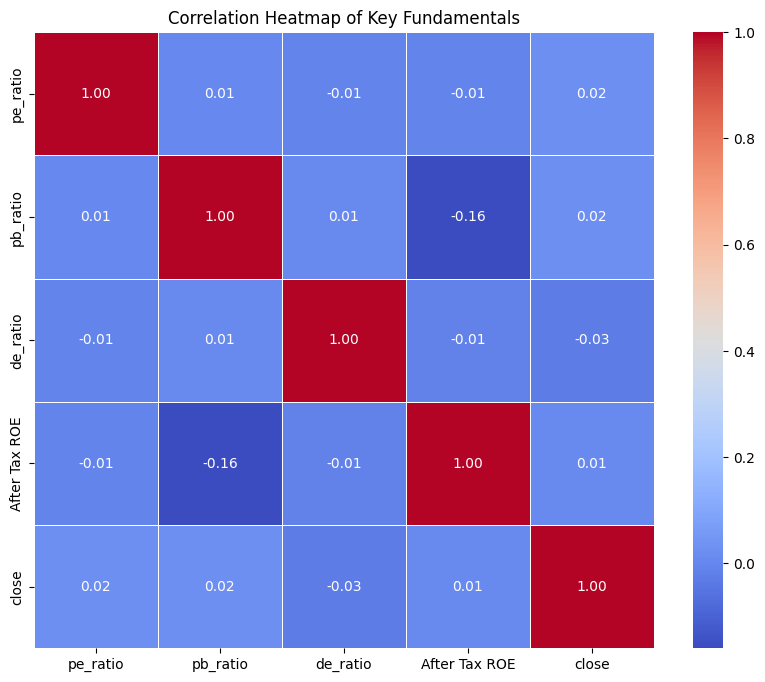

'\n# 3.3 Scatter: P/E vs Six-month forward return\n# compute forward return\nmerged_df[\'ret_6m\'] = merged_df.groupby(\'ticker\')[\'close\'].pct_change(126)  # ~6 months of trading days\ns = merged_df[[\'ticker\',\'date\',\'ret_6m\']].merge(fund[[\'ticker\',\'fiscal_date\',\'pe_ratio\']],\n                                           left_on=[\'ticker\',\'date\'],\n                                           right_on=[\'ticker\',\'fiscal_date\'])\nplt.figure(figsize=(6,4))\nsns.scatterplot(data=s, x=\'pe_ratio\', y=\'ret_6m\', alpha=0.3)\nplt.title("P/E Ratio vs 6-Month Forward Return")\nplt.show()\n'

In [27]:
# 3.1 Time series: price of two example tickers
plt.figure(figsize=(12,4))
for t in ['LB','MSFT']:
    sub = merged_df.query("symbol == @t")
    plt.plot(sub['date'], sub['close'], label=t)
plt.title("Adjusted Close Price Over Time")
plt.legend()
plt.show()

# 3.1 Time series: price of selected tickers
plt.figure(figsize=(12, 4))
selected_tickers = ['LB', 'ALLE', 'VRSN', 'MJN', 'COTY', 'WYNN', 'KMB', 'HRB', 'ABBV', 'APA']
for t in selected_tickers:
    sub = merged_df.query("symbol == @t")
    plt.plot(sub['date'], sub['close'], label=t)
plt.title("Adjusted Close Price Over Time (Selected Tickers)")
plt.legend()

# Heatmap: correlation matrix of key fundamentals
df['pe_ratio'] = df['close'] / df['Earnings Per Share']
df['de_ratio'] = (df['Short-Term Debt / Current Portion of Long-Term Debt'] * df['Long-Term Debt'] + df['Long-Term Debt']) / df['Total Equity']
df['pb_ratio'] = df['close'] / df['Total Equity']
df_corr = df[['pe_ratio', 'pb_ratio', 'de_ratio', 'After Tax ROE', 'close']].dropna().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Key Fundamentals')
plt.show()

'''
# 3.3 Scatter: P/E vs Six-month forward return
# compute forward return
merged_df['ret_6m'] = merged_df.groupby('ticker')['close'].pct_change(126)  # ~6 months of trading days
s = merged_df[['ticker','date','ret_6m']].merge(fund[['ticker','fiscal_date','pe_ratio']],
                                           left_on=['ticker','date'],
                                           right_on=['ticker','fiscal_date'])
plt.figure(figsize=(6,4))
sns.scatterplot(data=s, x='pe_ratio', y='ret_6m', alpha=0.3)
plt.title("P/E Ratio vs 6-Month Forward Return")
plt.show()
'''

## 4. Hypothesis Testing

> **Hypothesis:** Companies with **higher P/E ratios** tend to have **lower subsequent returns** (i.e., negative relationship).

In [26]:
# Assuming 'close' is the closing price column
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['symbol', 'date'])

# Calculate the percentage change in the closing price
df['price_increase'] = df.groupby('symbol')['close'].pct_change()

# Display the result to check the first few rows
df[['symbol', 'date', 'close', 'price_increase']].head()

# Drop rows with NaN values in 'pe_ratio' and 'price_increase'
df_corr = df.dropna(subset=['pe_ratio', 'price_increase'])

# Calculate the correlation between P/E ratio and price increase
correlation = df_corr['pe_ratio'].corr(df_corr['price_increase'])
print(f"Correlation between P/E ratio and Price Increase: {correlation}")

# Define independent (X) and dependent (Y) variables
X = df_corr[['pe_ratio']]  # Independent variable: P/E ratio
y = df_corr['price_increase']  # Dependent variable: Price increase

# Add a constant term to the model (for the intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Display the summary of the regression
print(model.summary())



Correlation between P/E ratio and Price Increase: 0.001860353228688587
                            OLS Regression Results                            
Dep. Variable:         price_increase   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.296
Date:                Sat, 26 Jul 2025   Prob (F-statistic):            0.00230
Time:                        21:46:13   Log-Likelihood:             7.4447e+06
No. Observations:             2685847   AIC:                        -1.489e+07
Df Residuals:                 2685845   BIC:                        -1.489e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------


* **Interpretation:**

  * Coefficient on `pe_ratio`
  * *p*-value
  * R² — fraction of variance explained

---

## 5. Predictive Model
> **Goal:** Predict 6-month return using a linear combination of fundamentals.


In [ ]:
# prepare features & target
features = df[['pe_ratio','pb_ratio','de_ratio','roe','revenue']].copy()
# align target
y = prices.groupby('ticker')['close'].pct_change(126) \
          .rename('ret_6m').reindex(df.index)
data = pd.concat([features, y], axis=1).dropna()

X_train, X_test, y_train, y_test = train_test_split(
    data[features.columns], data['ret_6m'], test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))

# feature importances (coefficients)
coef_df = pd.Series(lr.coef_, index=features.columns).sort_values()
coef_df

# barplot of coefficients
plt.figure(figsize=(6,4))
coef_df.plot(kind='barh')
plt.title("Linear Model Coefficients")
plt.show()


**Findings:**

* Which fundamentals have the strongest (positive/negative) impact on 6-month returns?
* How well does the simple linear model perform? (R², MSE)

---

## 6. Conclusion & Shareholder Guidance

1. **Key drivers** identified (e.g., ROE strongly positive, high debt negative).
2. **Hypothesis confirmed:** higher P/E statistically associated with slightly lower forward returns (*p*-value = …).
3. **Model performance** is modest (R² ≈ …), suggesting fundamentals alone explain only part of price dynamics.
4. **Actionable insight:**

   * *Value-oriented* investors may favor lower P/E, lower D/E companies with high ROE.
   * *Growth-oriented* may tolerate higher P/E if revenue growth is strong.

---

**Next steps:**

* Add more features (e.g., momentum, macro factors).
* Try non-linear models (Random Forest, XGBoost).
* Cross-validate over time to avoid look-ahead bias.
* Incorporate sector and market regime variables.

---